In [1]:
% matplotlib inline

In [2]:
import numpy as np
import scipy
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import pairwise_distances, r2_score
from scipy.linalg import cholesky
from scipy.linalg import solve_triangular
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from tqdm import tqdm

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
sns.set_style("ticks")
sns.set_style("white")
sns.set_palette(sns.color_palette("dark", 8))
plt_colors = sns.color_palette()
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams.update({'font.size': 12})

We only consider the state of Gujarat for now!

In [9]:
test_results = pd.read_csv("./test_results.csv")

In [10]:
df = test_results[test_results["state_idx"].isin(set([10, 19, 18]))]
df = df.loc[:,("pred", "true", "lat", "lng", "taluk_idx", "district_idx")]

In [11]:
print("Shape:", df.shape)

Shape: (106676, 6)


In [12]:
df.head()

,pred,true,lat,lng,taluk_idx,district_idx
26502,9.954368,10.019981,24.645664,71.817010,346,136
26935,9.870128,9.530176,24.435677,72.691155,345,136
27031,9.959000,9.677163,24.587483,72.326513,341,136
27078,9.532530,9.662257,23.300867,74.046501,445,150
27079,9.313933,9.212305,23.234691,74.137972,445,150


In [13]:
vmin = np.min(np.r_[df["true"], df["pred"]])
vmax = np.max(np.r_[df["true"], df["pred"]])

Text(0.5,1,'Predicted Expenditure')

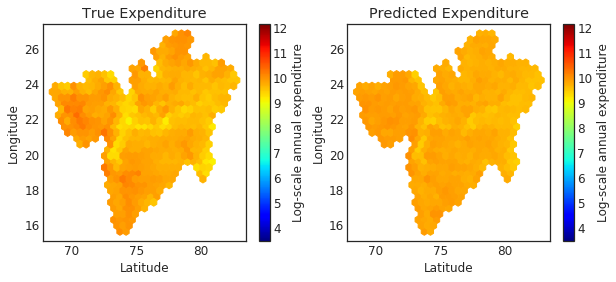

In [14]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.hexbin(df["lng"], df["lat"], C=df["true"], gridsize=30, cmap=cm.jet, vmax=vmax, vmin=vmin, mincnt=0)
cb = plt.colorbar()
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("True Expenditure")
plt.subplot(1,2,2)
plt.hexbin(df["lng"], df["lat"], C=df["pred"], gridsize=30, cmap=cm.jet, vmax=vmax, vmin=vmin, mincnt=0)
cb = plt.colorbar()
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Predicted Expenditure")

Aggregate to the taluk level for computational efficiency -- there are 651 taluks.

In [15]:
df = df.groupby("taluk_idx").mean().loc[:,("pred", "true", "lat", "lng")]

In [16]:
print("Shape", df.shape)

Shape (651, 4)


In [17]:
idxs = np.arange(len(df))
train_idxs = np.random.choice(idxs, int(0.5 * len(idxs)), replace=False)
val_idxs = np.array(list(set(idxs) - set(train_idxs)))

In [18]:
df_train = df.iloc[train_idxs,:]
df_val = df.iloc[val_idxs,:]

In [19]:
len(df_train), len(df_val)

(325, 326)

Text(0,0.5,'Latitude')

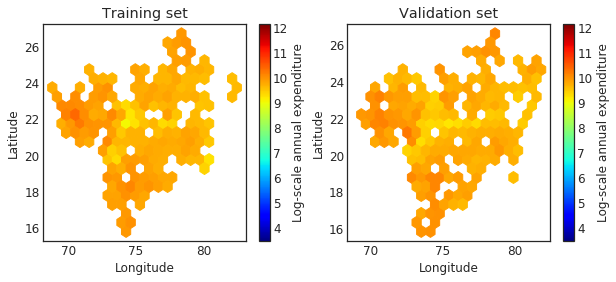

In [20]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
hb = plt.hexbin(df_train["lng"], df_train["lat"], gridsize=20, C=df_train["true"], cmap=cm.jet, vmax=vmax, vmin=vmin)
cb = plt.colorbar()
plt.title("Training set")
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.subplot(1,2,2)
hb = plt.hexbin(df_val["lng"], df_val["lat"], gridsize=20, C=df_val["true"], cmap=cm.jet, vmax=vmax, vmin=vmin)
cb = plt.colorbar()
plt.title("Validation set")
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

#### 1(a). Oracle: regress using (lat, lng) with all data points

In [1236]:
gbm = GradientBoostingRegressor(n_estimators=300)
gbm.fit(df_train.loc[:,("lat", "lng")], df_train["true"]);

In [1237]:
"R2 all training pts, loc only: %.3f" % r2_score(df_val["true"], gbm.predict(df_val.loc[:,("lat", "lng")]))

'R2 all training pts, loc only: 0.711'

#### 1(b). Oracle: using (lat, lng, pred) with all data points

In [1242]:
gp = GradientBoostingRegressor()
gp.fit(df_train.loc[:,("lat", "lng", "pred")], df_train["true"])
mean = gp.predict(df_val.loc[:,("lat", "lng", "pred")])

In [1243]:
print("R2 all training pts: %.3f" % r2_score(df_val["true"], mean))

R2 all training pts: 0.732


In [21]:
kernel = WhiteKernel() + \
         ConstantKernel() * \
         RBF(length_scale_bounds=(1e-3, 1000)) + \
         RBF(length_scale_bounds=(1e-3, 1000))

In [1245]:
df_train = df.iloc[train_idxs,:]
df_val = df.iloc[val_idxs,:]

In [1246]:
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp.fit(df_train.loc[:,("lat", "lng", "pred")], df_train["true"])
preds = gp.predict(df_val.loc[:, ("lat", "lng", "pred")])

In [1247]:
print("R2 all training pts, GP: %.3f" % r2_score(df_val["true"], preds))

R2 all training pts, GP: 0.842


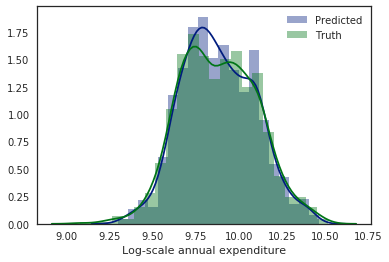

In [1248]:
sns.distplot(preds, label="Predicted")
sns.distplot(df_val["true"], label="Truth")
plt.xlabel("Log-scale annual expenditure")
plt.legend()

Text(0.5,0,'Longitude')

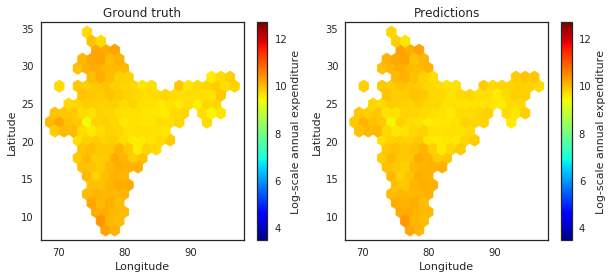

In [1251]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
hb = plt.hexbin(df_val["lng"], df_val["lat"], gridsize=20, C=df_val["true"], cmap=cm.jet, vmax=vmax, vmin=vmin)
cb = plt.colorbar()
plt.title("Ground truth")
cb.set_label("Log-scale annual expenditure")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.subplot(1,2,2)
hb = plt.hexbin(df_val["lng"], df_val["lat"], gridsize=20, C=preds, cmap=cm.jet, vmax=vmax, vmin=vmin)
cb = plt.colorbar()
plt.title("Predictions")
cb.set_label("Log-scale annual expenditure")
plt.ylabel("Latitude")
plt.xlabel("Longitude")

#### 2. Baseline: regress using satellite preds only with all data points

In [1254]:
lm = LinearRegression()
lm.fit(df_train.loc[:,("pred")].values.reshape(-1,1), df_train["true"]);

In [1255]:
print("R2 satellite only: %.3f" % r2_score(df_val["true"], df_val["pred"]))
print("R2 satellite only, LM: %.3f" % r2_score(df_val["true"], lm.predict(df_val.loc[:,("pred")].values.reshape(-1,1))))

R2 satellite only: 0.530
R2 satellite only, LM: 0.560


#### 3. Comparison: randomly pick 20 points and use (satellite data + lat + lng)

In [1256]:
bootstrap_r2s = []
for i in tqdm(range(100)):
  sampled_idxs = np.random.choice(np.arange(len(df_train)), 20, replace=False)
  df_sampled = df_train.iloc[sampled_idxs]
  gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
  gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"] - df_sampled["pred"])
  r2 = r2_score(df_val["true"], df_val["pred"] + gp.predict(df_val.loc[:,("lat", "lng")]))
  bootstrap_r2s.append(r2)

100%|██████████| 100/100 [00:05<00:00, 18.38it/s]


In [1257]:
"R2 20 random samples -- 95%% CI: [%.3f %.3f]" % tuple(np.percentile(bootstrap_r2s, (2.5, 97.5)))

'R2 20 random samples -- 95% CI: [0.359 0.604]'

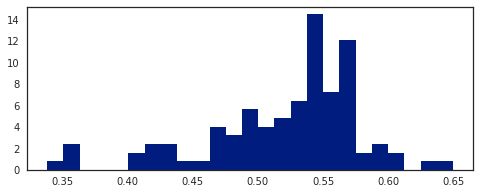

In [1258]:
plt.figure(figsize=(8, 3))
plt.hist(bootstrap_r2s, bins=25, density=True);

#### 4. GP: greedily pick 20 points and use (satellite data + lat + lng)

In [22]:
def greedy_selection(init_kernel, n_samples, X, y, chol_inv=True):
  
  remaining_indices = set(np.arange(len(X)))
  picked_indices = set()

  first_pick = np.random.randint(0, len(X))
  picked_indices.add(first_pick)
  remaining_indices.remove(first_pick)

  greedy_order = [first_pick]
  
  for i in tqdm(range(n_samples - 1)):

    gp = GaussianProcessRegressor(kernel=init_kernel, normalize_y=True)
    
    # Fit the GP with the points we've sampled so far
    # this does likelihood maximization to find kernel hyperparameters 
    # in addition to doing GP regression
    gp.fit(X[np.array(sorted(list(picked_indices)))], y[np.array(sorted(list(picked_indices)))])
    
    # This is kernel with ML estimates for hyperparams
    kernel = gp.kernel_
    
    # Compute the variance at the points that are available to sample
    var_y = np.diag(kernel(X[np.array(sorted(list(remaining_indices))),:]))

    # Find the covariance matrix for the sampled points and invert
    cov_AA = kernel(X[np.array(sorted(list(picked_indices)))])
    if chol_inv:
      chol = cholesky(cov_AA)
      inv_chol = scipy.linalg.solve_triangular(chol, np.identity(chol.shape[0]))
      inv_cov_AA = np.dot(inv_chol,np.transpose(inv_chol))
    else:
      inv_cov_AA = np.linalg.inv(cov_AA)

    # Find the kernel matrix of the picked points wrt remaining points
    cov_Ay = kernel(X[np.array(sorted(list(picked_indices)))], X[np.array(sorted(list(remaining_indices)))])
    cov_yA = np.transpose(cov_Ay)

    # Run the selection procedure over the remaining indices 
    # (note it is possible to speed this up: there is a section in the 
    # paper on speeding up this process for large numbers of points)
    max_delta_j, greedy_idx = float("-inf"), -1
    
    for idx, j in enumerate(sorted(list(remaining_indices))):
      
      cov_AbarAbar = kernel(X[np.array(sorted(list(remaining_indices - set([j])))),:])
      if chol_inv:
        chol = np.linalg.cholesky(cov_AbarAbar)
        inv_chol = scipy.linalg.solve_triangular(chol, np.identity(chol.shape[0]))
        inv_cov_AbarAbar = np.dot(inv_chol,np.transpose(inv_chol))
      else:
        inv_cov_AbarAbar = np.linalg.inv(cov_AbarAbar)

      cov_Abary = kernel(X[np.array(sorted(list(remaining_indices - set([j]))))], X[j,:][np.newaxis,:])
      cov_yAbar = np.transpose(cov_Abary)
      delta_j = (var_y[idx] - np.dot(np.dot(cov_yA[idx,:][np.newaxis,:],inv_cov_AA),
                                     cov_Ay[:,idx][:,np.newaxis]))/(var_y[idx] - np.dot(np.dot(cov_yAbar,inv_cov_AbarAbar),cov_Abary))
      delta_j = delta_j.flatten()[0]

      if delta_j > max_delta_j:
        max_delta_j = delta_j
        greedy_idx = j

    picked_indices.add(greedy_idx)
    remaining_indices.remove(greedy_idx)
    greedy_order.append(greedy_idx)
    
  return greedy_order

In [23]:
kernel = WhiteKernel() + \
         ConstantKernel() * \
         RBF(length_scale_bounds=(1e-3, 1000)) + \
         RBF(length_scale_bounds=(1e-3, 1000))

In [25]:
idxs = greedy_selection(
  kernel, 20,
  df_train.loc[:,("lat", "lng", "pred")].as_matrix(),
  np.array(df_train["true"] - df_train["pred"]), chol_inv=False)

100%|██████████| 19/19 [00:51<00:00,  2.69s/it]


In [24]:
idxs_nosat = greedy_selection(
  kernel, 20, 
  df_train.loc[:,("lat", "lng")].as_matrix(),
  np.array(df_train["true"] - df_train["pred"]), chol_inv=False)

100%|██████████| 19/19 [00:50<00:00,  2.63s/it]


In [1132]:
df_sampled = df_train.iloc[np.array(idxs_nosat[:8]),:]

In [1133]:
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"] - df_sampled["pred"])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=1) + 1**2 * RBF(length_scale=1) + RBF(length_scale=1),
             n_restarts_optimizer=0, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [1134]:
mean, std = gp.predict(df_val.loc[:,("lat", "lng",)], return_std=True)

In [1135]:
gp.kernel_

WhiteKernel(noise_level=1e-05) + 0.0459**2 * RBF(length_scale=2.44) + RBF(length_scale=1e+03)

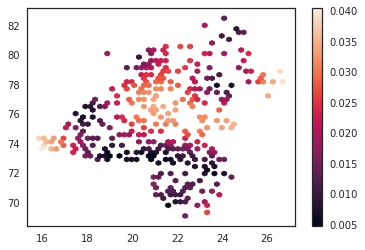

In [1136]:
plt.figure(figsize=(6,4))
plt.hexbin(df_val["lat"], df_val["lng"], C=std, gridsize=50)
cb = plt.colorbar()

Text(0.5,1,'Train set')

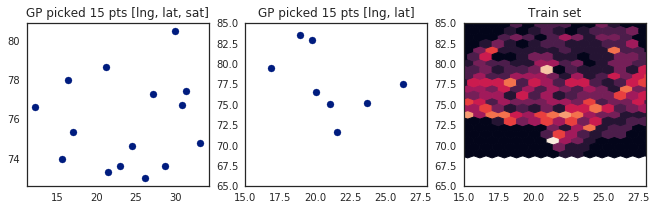

In [1262]:
plt.figure(figsize=(15, 3))
plt.subplot(1,4,1)
df_sampled = df_train.iloc[idxs[:15],:]
plt.ylim((65, 85))
plt.xlim((15,28))
plt.scatter(df_sampled["lat"], df_sampled["lng"])
plt.title("GP picked 15 pts [lng, lat, sat]")
plt.subplot(1,4,2)
df_sampled = df_train.iloc[idxs_nosat[:15],:]
plt.ylim((65, 85))
plt.xlim((15,28))
plt.scatter(df_sampled["lat"], df_sampled["lng"])
plt.title("GP picked 15 pts [lng, lat]")
plt.subplot(1,4,3)
plt.hexbin(df_train["lat"], df_train["lng"], gridsize=30)
plt.ylim((65, 85))
plt.xlim((15, 28))
plt.title("Train set")

In [ ]:
r2s_gp_matrix = []
for _ in range(2):
  r2s_gp = []
  idxs = greedy_selection(
    kernel, 120, 
    df_train.loc[:,("lat", "lng", "pred")].as_matrix(),
    np.array(df_train["true"] - df_train["pred"]), chol_inv=False)
  for i in tqdm(range(1, len(idxs) + 1)):
    df_sampled = df_train.iloc[idxs[:i],:]
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"] - df_sampled["pred"])
    r2 = r2_score(df_val["true"], df_val["pred"] + gp.predict(df_val.loc[:,("lat", "lng")]))
    r2s_gp.append(r2)
  r2s_gp_matrix.append(r2s_gp)

  5%|▌         | 6/119 [11:46<3:41:44, 117.74s/it]

In [ ]:
r2s_gp_nosat_matrix = []
for _ in range(2):
  r2s_gp_nosat = []
  idxs_nosat = greedy_selection(
    kernel, 120, 
    df_train.loc[:,("lat", "lng")].as_matrix(),
    np.array(df_train["true"] - df_train["pred"]), chol_inv=False)
  for i in tqdm(range(1, len(idxs_nosat) + 1)):
    df_sampled = df_train.iloc[idxs_nosat[:i],:]
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"] - df_sampled["pred"])
    r2 = r2_score(df_val["true"], df_val["pred"] + gp.predict(df_val.loc[:,("lat", "lng")]))
    r2s_gp_nosat.append(r2)
  r2s_gp_nosat_matrix.append(r2s_gp_nosat)

In [ ]:
r2s_random_matrix = []
for _ in range(10):
  r2s_random = []
  idxs_random = np.arange(len(df_train))
  np.random.shuffle(idxs_random)
  for i in tqdm(range(1, 500)):
    df_sampled = df_train.iloc[idxs_random[:i],:]
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gp.fit(df_sampled.loc[:,("lat", "lng", "pred")], df_sampled["true"] - df_sampled["pred"])
    r2 = r2_score(df_val["true"], df_val["pred"] + gp.predict(df_val.loc[:,("lat", "lng", "pred")]))
    r2s_random.append(r2)
  r2s_random_matrix.append(r2s_random)

 95%|█████████▍| 473/499 [01:28<00:04,  5.36it/s]

In [1287]:
r2s_random_nosat_matrix = []
for _ in range(10):
  r2s_random_nosat = []
  idxs_random = np.arange(len(df_train))
  np.random.shuffle(idxs_random)
  for i in tqdm(range(1, 500)):
    df_sampled = df_train.iloc[idxs_random[:i],:]
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"])
    r2 = r2_score(df_val["true"], gp.predict(df_val.loc[:,("lat", "lng")]))
    r2s_random_nosat.append(r2)
  r2s_random_nosat_matrix.append(r2s_random_nosat)

100%|██████████| 499/499 [01:31<00:00,  5.46it/s]


In [1274]:
np.save("./r2s_gp_matrix", np.array(r2s_gp_matrix))

In [1275]:
np.save("./r2s_gp_nosat_matrix", np.array(r2s_gp_nosat_matrix))

In [1276]:
np.save("./r2s_random_matrix", np.array(r2s_random_matrix))

In [1277]:
np.save("./r2s_random_nosat_matrix", np.array(r2s_random_nosat_matrix))

In [1283]:
np.array(r2s_random_matrix).shape

(10, 499)

In [28]:
plt.figure(figsize=(10, 3))
# sns.tsplot(r2s_gp_matrix, condition="Greedy GP [lat, lng, sat]", color=plt_colors[0], ci=95)
# sns.tsplot(r2s_gp_nosat_matrix, condition="Greedy GP [lat, lng]", color=plt_colors[1], ci=95)
sns.tsplot(r2s_random_matrix, condition="Random [lat, lng, sat]", color=plt_colors[2], ci=95)
sns.tsplot(r2s_random_nosat_matrix, condition="Random [lat, lng]", color=plt_colors[3], ci=95)
plt.xlabel("Number of taluks sampled in the training set")
plt.ylabel("$R^2$")
plt.axhline(r2_score(df_val["true"], df_val["pred"]), ls="--", color="grey", label="Sat only")
plt.axhline(r2_score(df_val["true"], preds), ls="--", color="grey", label="All train data")
plt.ylim(0, 0.9)
plt.legend();

NameError: name 'r2s_random_matrix' is not defined

In [26]:
plt.figure(figsize=(10, 3))
# sns.tsplot(r2s_gp_matrix, condition="Greedy GP [lat, lng, sat]", color=plt_colors[0], ci=95)
# sns.tsplot(r2s_gp_nosat_matrix, condition="Greedy GP [lat, lng]", color=plt_colors[1], ci=95)
sns.tsplot(r2s_random_matrix, condition="Random [lat, lng, sat]", color=plt_colors[2], ci=95)
sns.tsplot(r2s_random_nosat_matrix, condition="Random [lat, lng]", color=plt_colors[3], ci=95)
plt.xlabel("Number of taluks sampled in the training set")
plt.ylabel("$R^2$")
plt.axhline(r2_score(df_val["true"], df_val["pred"]), ls="--", color="grey", label="Sat only")
plt.axhline(r2_score(df_val["true"], preds), ls="--", color="grey", label="All train data")
plt.ylim(0, 0.9)
plt.legend();

NameError: name 'r2s_random_matrix' is not defined

In [1292]:
kernel = WhiteKernel() + \
         ConstantKernel() * \
         RBF(length_scale_bounds=(1e-3, 1000)) + \
         RBF(length_scale_bounds=(1e-3, 1000))

In [1294]:
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp.fit(df_train.loc[:,("lat", "lng", "pred")], df_train["true"] - df_train["pred"])
preds = gp.predict(df_val.loc[:, ("lat", "lng", "pred")]) + df_val["pred"]

In [1295]:
r2_score(df_val["true"], preds)

0.8269556704355209

Text(0.5,0,'Longitude')

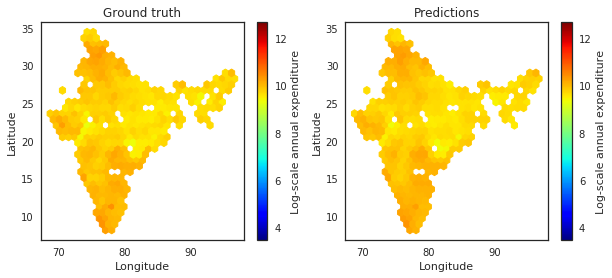

In [1303]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
hb = plt.hexbin(df_val["lng"], df_val["lat"], gridsize=30, C=df_val["true"], cmap=cm.jet, vmax=vmax, vmin=vmin)
cb = plt.colorbar()
plt.title("Ground truth")
cb.set_label("Log-scale annual expenditure")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.subplot(1,2,2)
hb = plt.hexbin(df_val["lng"], df_val["lat"], gridsize=30, C=preds, cmap=cm.jet, vmax=vmax, vmin=vmin)
cb = plt.colorbar()
plt.title("Predictions")
cb.set_label("Log-scale annual expenditure")
plt.ylabel("Latitude")
plt.xlabel("Longitude")